# 2018 Green Taxi Machine Learning Analysis
## DATA607 Final Project

#### Linzi Jiang, Cheryl Kwong

In [ ]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }

 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>

The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

The dataset we would like to analyze is the NYC taxi trip record (https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page). The dataset contains monthly data of three different taxi companies Yellow, Green and FHV between years 2009 and 2018. The dataset includes datetime, non-categorical, categorical data such as vendor ID (category 1, 2), pickup/dropoff date time, passenger count, trip distance, rate code ID (category 1-6), pickup/destiny location ID (265 categories), payment type (category 1-6), amounts (fare, tips, total amount), trip type (category 1, 2) etc. The data source also contains a separate taxi zone look up (mapping) file to map location ID to borough/zone/service_zone which we will be using to further our analysis. We will be using December 2018 data for Green Taxis which is 58.5MB in size. We might also use a subset of the data in order to speed up the processing and calculation. 

Ultimately, the purpose of the project is to compare the performance of Decision Tree, Random Forest, and Bagging Classifier. Along with determining the number of layers or complexity of the Neural Network required to build an effective prediction model. The Neural Network is to see if we can build an automated model to accurately predict all different taxi data (different taxi companies, different months or years).


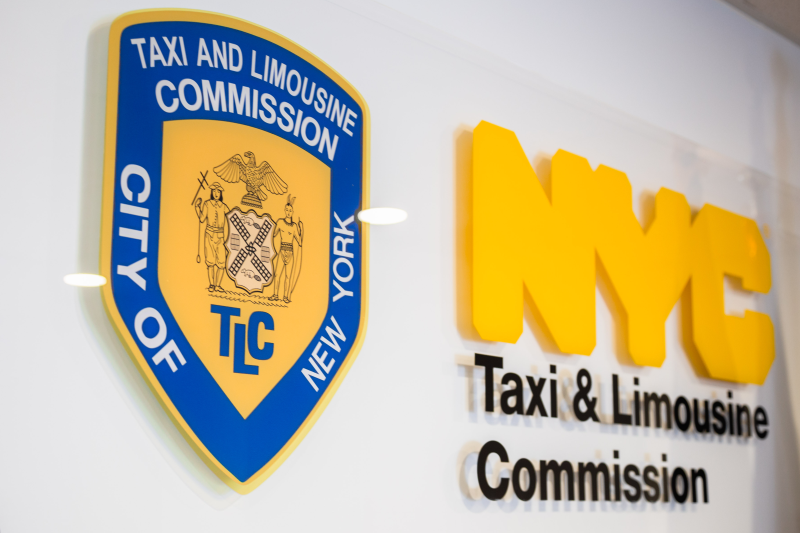

In [32]:
import IPython
url = 'https://www1.nyc.gov/assets/tlc/images/content/pages/about/about-tlc.png'
IPython.display.Image(url, width = 500)

## Important Packages

In [16]:
from __future__ import absolute_import, division, print_function
import tensorflow as tf
from tensorflow import keras

from matplotlib import pyplot as plt

import sklearn.metrics as skm
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

import pandas as pd
import numpy as np
# import plotly

%matplotlib inline
import seaborn as sns
sns.set(style='white', color_codes=True, font_scale=1.3)

import warnings
warnings.filterwarnings("ignore")

# Basic Visualizations

In [17]:
raw_data = pd.read_csv("https://s3.amazonaws.com/nyc-tlc/trip+data/green_tripdata_2018-12.csv")

raw_data.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type
0,2,2018-12-01 00:23:25,2018-12-01 00:24:47,N,1,193,193,1,0.00,3.0,0.5,0.5,0.00,0.0,NaN,0.3,4.30,2,1.0
1,2,2018-11-30 23:58:31,2018-12-01 00:21:53,N,1,80,82,2,5.75,21.0,0.5,0.5,0.00,0.0,NaN,0.3,22.30,2,1.0
2,2,2018-12-01 00:21:03,2018-12-01 00:30:15,N,1,225,225,1,1.55,8.0,0.5,0.5,1.86,0.0,NaN,0.3,11.16,1,1.0
3,2,2018-12-01 00:15:56,2018-12-01 00:23:26,N,1,75,236,2,1.32,7.0,0.5,0.5,0.00,0.0,NaN,0.3,8.30,1,1.0
4,2,2018-12-01 00:28:32,2018-12-01 00:30:33,N,1,75,75,2,0.68,4.0,0.5,0.5,1.06,0.0,NaN,0.3,6.36,1,1.0


In [3]:
raw_data_sample=raw_data.sample(frac=0.001)
raw_data_sample.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type
29505,2,2018-12-02 07:52:39,2018-12-02 08:31:42,N,1,254,246,1,16.15,47.50,0.0,0.5,0.00,0.0,NaN,0.3,48.30,1,1.0
619026,2,2018-12-28 17:09:39,2018-12-28 17:48:31,N,5,74,242,1,7.75,25.98,0.0,0.5,0.00,0.0,NaN,0.0,26.48,1,2.0
36764,2,2018-12-02 15:43:14,2018-12-02 16:02:17,N,1,189,66,1,2.33,13.50,0.0,0.5,2.86,0.0,NaN,0.3,19.11,1,1.0
58759,1,2018-12-03 16:54:43,2018-12-03 17:12:27,N,1,126,32,1,4.60,16.50,1.0,0.5,2.75,0.0,NaN,0.3,21.05,1,1.0
538260,2,2018-12-23 23:06:15,2018-12-23 23:09:57,N,1,41,74,1,0.85,5.00,0.5,0.5,2.00,0.0,NaN,0.3,8.30,1,1.0


In [4]:
raw_data_sample = raw_data_sample.drop(['lpep_pickup_datetime', 'lpep_dropoff_datetime', 'ehail_fee', 'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge'], axis=1)
raw_data_sample.head()

,VendorID,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,total_amount,payment_type,trip_type
29505,2,N,1,254,246,1,16.15,48.30,1,1.0
619026,2,N,5,74,242,1,7.75,26.48,1,2.0
36764,2,N,1,189,66,1,2.33,19.11,1,1.0
58759,1,N,1,126,32,1,4.60,21.05,1,1.0
538260,2,N,1,41,74,1,0.85,8.30,1,1.0


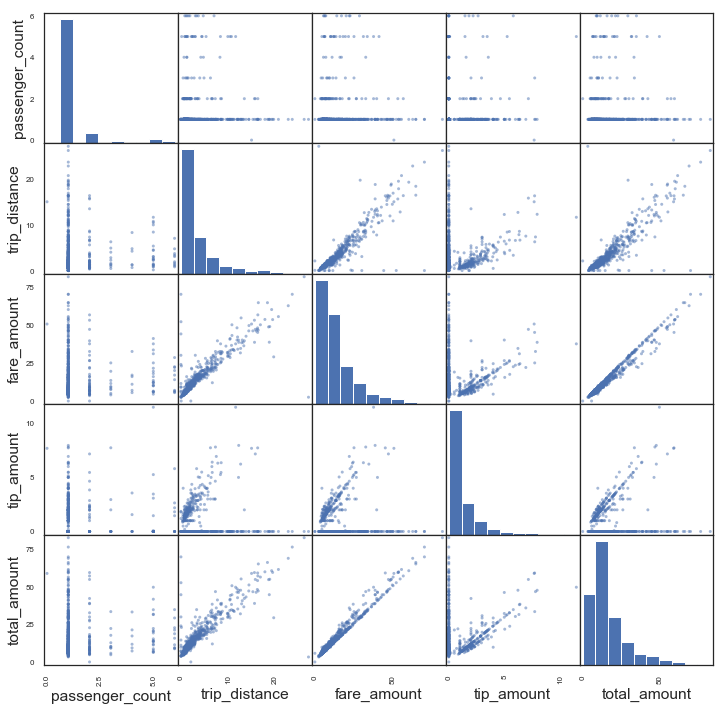

In [5]:
raw_data_sample=raw_data.sample(frac=0.001)
raw_data_sample = raw_data_sample[['passenger_count', 'trip_distance', 'fare_amount', 'tip_amount', 'total_amount']].copy()
_ = pd.plotting.scatter_matrix(raw_data_sample, figsize=(12,12))

# Data Preparation

In [18]:
# Cleaning data columns with dates to correct years (assuming data is correct)
raw_data = raw_data.replace(['2008'], ['2018'], regex=True) 

# Converting date columnes to datetime objects
raw_data['lpep_pickup_datetime'] = pd.to_datetime(raw_data['lpep_pickup_datetime'])
raw_data['lpep_dropoff_datetime'] = pd.to_datetime(raw_data['lpep_dropoff_datetime'])


raw_data['travel_time'] = (raw_data['lpep_dropoff_datetime'] - raw_data['lpep_pickup_datetime']).dt.total_seconds()
raw_data['pickup_year'] = raw_data.lpep_pickup_datetime.dt.year
raw_data['pickup_month'] = raw_data.lpep_pickup_datetime.dt.month
raw_data['pickup_day'] = raw_data.lpep_pickup_datetime.dt.day
raw_data['pickup_hour'] = raw_data.lpep_pickup_datetime.dt.hour

# Maintain 2018 data and maintain 2019 Jan 1 data (new years)
raw_data = raw_data[raw_data['pickup_year']==2018]
raw_data = raw_data[raw_data['pickup_month']==12]

# Reorder year,month,day columns in front
cols = raw_data.columns.tolist()
cols = cols[-4:] + cols[:-4]
raw_data = raw_data[cols]
raw_data = raw_data.drop(['pickup_year', 'pickup_month', 'ehail_fee'], axis=1)

raw_data = raw_data[raw_data['RatecodeID'] != 99]

# [0 for i in data['store_and_fwd_flag'] if N else 1]
raw_data['store_and_fwd_flag'] = [0 if i == 'N' else 1 for i in raw_data['store_and_fwd_flag']]
raw_data.head()

,pickup_day,pickup_hour,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,...,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,payment_type,trip_type,travel_time
0,1,0,2,2018-12-01 00:23:25,2018-12-01 00:24:47,0,1,193,193,1,...,3.0,0.5,0.5,0.00,0.0,0.3,4.30,2,1.0,82.0
2,1,0,2,2018-12-01 00:21:03,2018-12-01 00:30:15,0,1,225,225,1,...,8.0,0.5,0.5,1.86,0.0,0.3,11.16,1,1.0,552.0
3,1,0,2,2018-12-01 00:15:56,2018-12-01 00:23:26,0,1,75,236,2,...,7.0,0.5,0.5,0.00,0.0,0.3,8.30,1,1.0,450.0
4,1,0,2,2018-12-01 00:28:32,2018-12-01 00:30:33,0,1,75,75,2,...,4.0,0.5,0.5,1.06,0.0,0.3,6.36,1,1.0,121.0
5,1,0,2,2018-12-01 00:50:07,2018-12-01 00:55:51,0,1,75,263,2,...,6.0,0.5,0.5,1.00,0.0,0.3,8.30,1,1.0,344.0


# DataFrame for Boroughs

In [19]:
zone_lookup = pd.read_csv("https://s3.amazonaws.com/nyc-tlc/misc/taxi+_zone_lookup.csv")
zone_lookup.head()

,LocationID,Borough,Zone,service_zone
0,1,EWR,Newark Airport,EWR
1,2,Queens,Jamaica Bay,Boro Zone
2,3,Bronx,Allerton/Pelham Gardens,Boro Zone
3,4,Manhattan,Alphabet City,Yellow Zone
4,5,Staten Island,Arden Heights,Boro Zone


In [20]:
bname = ["Bronx", "Brooklyn", "EWR" ,"Manhattan", "Queens", "Staten Island", "Unknown"]
Borough = dict(zip(bname, range(1,8)))
Borough

{'Bronx': 1,
 'Brooklyn': 2,
 'EWR': 3,
 'Manhattan': 4,
 'Queens': 5,
 'Staten Island': 6,
 'Unknown': 7}

In [21]:
dict_bor = {}
for i in bname:
    lookup = zone_lookup[zone_lookup['Borough'] == i].LocationID.tolist()
    for j in lookup:
        dict_bor[j] = i

PUBorough = [dict_bor[i] for i in raw_data['PULocationID'].tolist()]
raw_data['PUBorough'] = [Borough[i] for i in PUBorough]

DOBorough = [dict_bor[i] for i in raw_data['DOLocationID'].tolist()]
raw_data['DOBorough'] = [Borough[i] for i in DOBorough]

In [22]:
raw_data.reset_index(inplace=True)
raw_data.head()

,index,pickup_day,pickup_hour,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,...,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,payment_type,trip_type,travel_time,PUBorough,DOBorough
0,0,1,0,2,2018-12-01 00:23:25,2018-12-01 00:24:47,0,1,193,193,...,0.5,0.00,0.0,0.3,4.30,2,1.0,82.0,5,5
1,2,1,0,2,2018-12-01 00:21:03,2018-12-01 00:30:15,0,1,225,225,...,0.5,1.86,0.0,0.3,11.16,1,1.0,552.0,2,2
2,3,1,0,2,2018-12-01 00:15:56,2018-12-01 00:23:26,0,1,75,236,...,0.5,0.00,0.0,0.3,8.30,1,1.0,450.0,4,4
3,4,1,0,2,2018-12-01 00:28:32,2018-12-01 00:30:33,0,1,75,75,...,0.5,1.06,0.0,0.3,6.36,1,1.0,121.0,4,4
4,5,1,0,2,2018-12-01 00:50:07,2018-12-01 00:55:51,0,1,75,263,...,0.5,1.00,0.0,0.3,8.30,1,1.0,344.0,4,4


##### Convert categorical data to one-hot vectors

In [23]:
# Numerical data columns
numcol = ['pickup_day',
        'pickup_hour', 'passenger_count', 'trip_distance',
        'fare_amount', 'extra', 'mta_tax', 'tip_amount',
        'tolls_amount', 'improvement_surcharge', 'total_amount', 'travel_time']

# Categorical data columns (to be converted to one-hot vectors for Neural Networks later)
one_hot = ['VendorID', 'RatecodeID', 'trip_type', 
           'store_and_fwd_flag', 'PUBorough']

In [24]:
from sklearn.preprocessing import OneHotEncoder

# Function to convert categorical columns to one-hot vector
def convert_to_onehot(dataframe, colname_to_convert): 
    unique_value = dataframe[colname_to_convert].unique().tolist()
    x_ = dataframe[colname_to_convert].values.reshape(-1, 1)
    
    encoder = OneHotEncoder(sparse=False, categories='auto')
    x = encoder.fit_transform(x_)
    return x, unique_value

In [25]:
# To take all the categorical predictor variables to convert in to one-hot vectors and add to the dataframe
onehotdict = {}
numerical_df = raw_data[numcol]

for colname in one_hot:
    x, unique_value=convert_to_onehot(raw_data, colname)
    onehotdict[colname] = [x, unique_value]
    df = pd.DataFrame(onehotdict[colname][0], columns=[colname + "_" + str(i) for i in onehotdict[colname][1]])
    numerical_df = numerical_df.join(df)

In [26]:
# Normalize the data to improve machine learning techniques.

num_norm = numerical_df.values
cols = numerical_df.columns.tolist()
StandardScaler(copy=False).fit(num_norm).transform(num_norm)

grouped_df = pd.DataFrame(num_norm, columns = cols)
grouped_df['DOBorough'] = raw_data['DOBorough']

grouped_df.head()

,pickup_day,pickup_hour,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,...,store_and_fwd_flag_0,store_and_fwd_flag_1,PUBorough_5,PUBorough_2,PUBorough_4,PUBorough_1,PUBorough_7,PUBorough_6,PUBorough_3,DOBorough
0,-1.641569,-2.347243,-0.323808,-0.852057,-0.902939,0.488934,0.133958,-0.491214,-0.190621,0.268165,...,0.044594,-0.044594,-0.273981,-0.677862,-0.003417,-0.671587,1.518855,-0.020998,-0.040786,5
1,-1.641569,-2.347243,-0.323808,-0.467825,-0.496972,0.488934,0.133958,0.476191,-0.190621,0.268165,...,0.044594,-0.044594,-0.273981,1.475226,-0.003417,-0.671587,-0.658391,-0.020998,-0.040786,2
2,-1.641569,-2.347243,0.690181,-0.524840,-0.578165,0.488934,0.133958,-0.491214,-0.190621,0.268165,...,0.044594,-0.044594,-0.273981,-0.677862,-0.003417,1.489010,-0.658391,-0.020998,-0.040786,4
3,-1.641569,-2.347243,0.690181,-0.683491,-0.821746,0.488934,0.133958,0.060103,-0.190621,0.268165,...,0.044594,-0.044594,-0.273981,-0.677862,-0.003417,1.489010,-0.658391,-0.020998,-0.040786,4
4,-1.641569,-2.347243,0.690181,-0.611602,-0.659359,0.488934,0.133958,0.028897,-0.190621,0.268165,...,0.044594,-0.044594,-0.273981,-0.677862,-0.003417,1.489010,-0.658391,-0.020998,-0.040786,4


# K-nearest Neighbors (KNN) Classifer

### Obtain K Based on Reduced Sample Size (0.01)

In [12]:
grouped_df_sample = grouped_df.sample(frac=0.01)
display(grouped_df_sample.head())
values = grouped_df_sample.values
X_sample = values[:, :-1]
y_sample = values[:, -1]
X_train_sample, X_test_sample, y_train_sample, y_test_sample = train_test_split(X_sample, y_sample, test_size = 0.2)

,pickup_day,pickup_hour,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,...,store_and_fwd_flag_0,store_and_fwd_flag_1,PUBorough_5,PUBorough_2,PUBorough_4,PUBorough_1,PUBorough_7,PUBorough_6,PUBorough_3,DOBorough
374,-1.641569,-2.347243,0.690181,0.660084,0.558543,0.488934,0.133958,-0.491214,-0.190621,0.268165,...,0.044594,-0.044594,3.649889,-0.677862,-0.003417,-0.671587,-0.658391,-0.020998,-0.040786,4
681495,1.790696,1.396282,-0.323808,-0.361231,-0.375182,0.488934,0.133958,-0.491214,-0.190621,0.268165,...,0.044594,-0.044594,-0.273981,1.475226,-0.003417,-0.671587,-0.658391,-0.020998,-0.040786,2
585358,1.218652,1.396282,-0.323808,-0.698364,-0.781149,0.488934,0.133958,-0.491214,-0.190621,0.268165,...,0.044594,-0.044594,-0.273981,-0.677862,-0.003417,1.489010,-0.658391,-0.020998,-0.040786,4
401294,0.303381,-1.156121,-0.323808,1.309561,1.411074,-0.786234,0.133958,-0.491214,4.526803,0.268165,...,0.044594,-0.044594,-0.273981,1.475226,-0.003417,-0.671587,-0.658391,-0.020998,-0.040786,4
475004,0.646607,-1.156121,-0.323808,-0.636391,-0.537569,-0.786234,0.133958,-0.491214,-0.190621,0.268165,...,0.044594,-0.044594,-0.273981,-0.677862,-0.003417,1.489010,-0.658391,-0.020998,-0.040786,4


(8, 9)

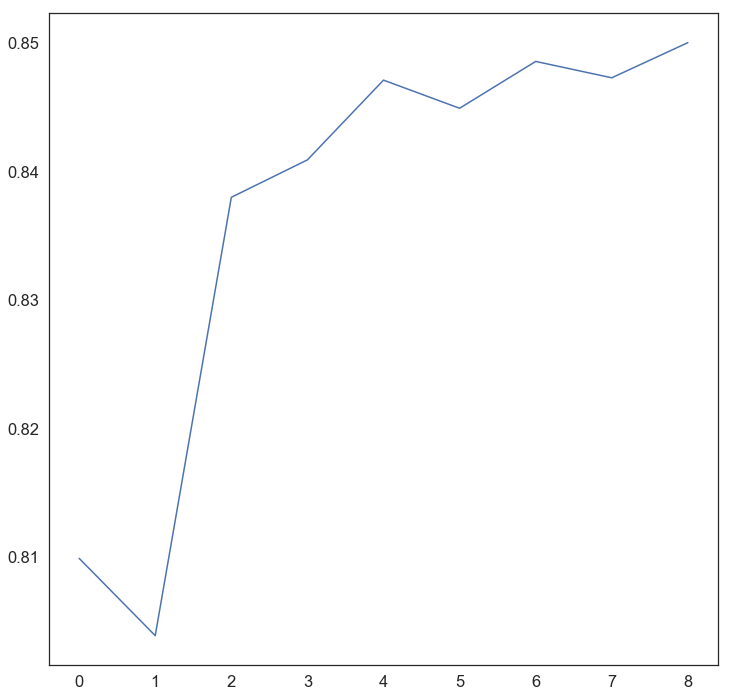

In [134]:
cv_scores_sample = []
for k in range(1, 10):
    KC = KNeighborsClassifier(n_neighbors=k)
    KC.fit(X_train_sample, y_train_sample)
    y_ = KC.predict(X_test_sample)
    cv_score_sample = cross_val_score(KC, X_train_sample, y_train_sample, scoring="accuracy")
    cv_scores_sample.append(cv_score_sample)
cv_scores_sample = np.array(cv_scores_sample)
cv_scores_sample.shape
plt.plot(np.mean(cv_scores_sample, axis=1))
np.argmax(np.mean(cv_scores_sample, axis=1)), range(1,10)[np.argmax(np.mean(cv_scores_sample, axis=1))]

We have executed the codes several times which generated the same result. Based on the diagram above, K should be between 8 and 9. Therefore, we selected k=8 for our further classification analysis over the full dataset.

In [135]:
KC = KNeighborsClassifier(n_neighbors=8)

X_train, X_test, y_train, y_test = train_test_split(X_train_sample, y_train_sample, test_size = 0.2)
KC.fit(X_train, y_train)
y_ = KC.predict(X_test)
sum(y_ == y_test)/len(y_)
print(f"Misclassification rate: {1 - sum(y_ == y_test)/len(y_):.2f}")

Misclassification rate: 0.16


In [136]:
cv_score1 = cross_val_score(KC, X_train_sample, y_train_sample, scoring="accuracy", cv=5).mean()
print(f"Average of accuracy: {cv_score1}")

Average of accuracy: 0.8492945627765671


In [137]:
# Compute the confusion matrix
neigh_cfmat = skm.confusion_matrix(
    y_true=y_test,
    y_pred=y_,)
neigh_cfmat[:4:4]

array([[62,  0,  0, 29,  4]], dtype=int64)

In [35]:
Borough = dict(zip(range(1,8), bname))

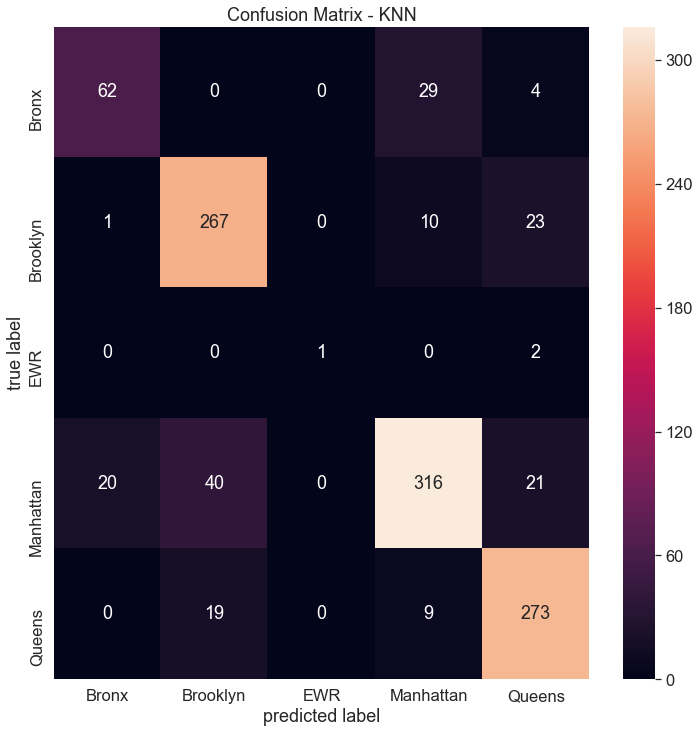

In [139]:
# Visualize the confusion matrix
labels = [Borough[int(i)] for i in np.unique(y_test)]
sns.heatmap(neigh_cfmat, 
            xticklabels=labels,
            yticklabels=labels,
            annot=True, fmt='g')

plt.xlabel('predicted label')
plt.ylabel('true label')
plt.title('Confusion Matrix - KNN')
sns.set(style='white', color_codes=True, font_scale=1.5, rc={'figure.figsize':(12,12)})

Based on the Confusion Matrix diagram above, destination borough where the most transactions tend to have better prediction results - Brooklyn, Manhattan and Queens. The accuracy rate of those three boroughs are 0.8470, 0.8427 and 0.8875 which are close to the average accuracy rate of this KNN model. The result is not very optimistic and hence we looked into other regression models - Decision Tree and Random Forest below.

# Decision Tree Classifier

### Decision Tree Analysis Including all Features

In [26]:
display(grouped_df.head())
grouped_df_sample=grouped_df.sample(frac=0.2)
values = grouped_df_sample.values

X_train_sample = values[:, :-1]
y_train_sample = values[:, -1]

,pickup_day,pickup_hour,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,...,store_and_fwd_flag_0,store_and_fwd_flag_1,PUBorough_5,PUBorough_2,PUBorough_4,PUBorough_1,PUBorough_7,PUBorough_6,PUBorough_3,DOBorough
0,-1.641569,-2.347243,-0.323808,-0.852057,-0.902939,0.488934,0.133958,-0.491214,-0.190621,0.268165,...,0.044594,-0.044594,-0.273981,-0.677862,-0.003417,-0.671587,1.518855,-0.020998,-0.040786,5
1,-1.641569,-2.347243,-0.323808,-0.467825,-0.496972,0.488934,0.133958,0.476191,-0.190621,0.268165,...,0.044594,-0.044594,-0.273981,1.475226,-0.003417,-0.671587,-0.658391,-0.020998,-0.040786,2
2,-1.641569,-2.347243,0.690181,-0.524840,-0.578165,0.488934,0.133958,-0.491214,-0.190621,0.268165,...,0.044594,-0.044594,-0.273981,-0.677862,-0.003417,1.489010,-0.658391,-0.020998,-0.040786,4
3,-1.641569,-2.347243,0.690181,-0.683491,-0.821746,0.488934,0.133958,0.060103,-0.190621,0.268165,...,0.044594,-0.044594,-0.273981,-0.677862,-0.003417,1.489010,-0.658391,-0.020998,-0.040786,4
4,-1.641569,-2.347243,0.690181,-0.611602,-0.659359,0.488934,0.133958,0.028897,-0.190621,0.268165,...,0.044594,-0.044594,-0.273981,-0.677862,-0.003417,1.489010,-0.658391,-0.020998,-0.040786,4


In [74]:
DC = DecisionTreeClassifier()
n = 10
scores = []
fis = []
for i in range(n):
    X_train, X_test, y_train, y_test = train_test_split(X_train_sample, y_train_sample, test_size = 0.2)
    DC.fit(X_train, y_train)
    y_pred = DC.predict(X_test)

    score = cross_val_score(DC, X_train_sample, y_train_sample, scoring="accuracy", cv=5).mean()
    scores.append(score)
    fi = DC.feature_importances_
    fis.append(fi)

In [75]:
print(f"Average of accuracy: {np.mean(scores)}")
print(f"Standard deviation of accuracy: {np.std(scores)}")

Average of accuracy: 0.831797100001044
Standard deviation of accuracy: 0.0002970779423818822


In [76]:
# Average feature importances
fis_avg = np.mean(fis, axis=0)
fis_avg

array([3.69114025e-02, 3.23807833e-02, 6.79785684e-03, 9.90408270e-02,
       2.23276244e-02, 5.29897123e-03, 5.60360530e-04, 2.28040893e-02,
       3.78527026e-02, 6.94898753e-04, 5.98790218e-02, 6.35035768e-02,
       2.74612885e-03, 2.96167239e-03, 8.31293555e-04, 2.80872054e-04,
       3.49457553e-05, 4.36121763e-04, 1.04101119e-03, 0.00000000e+00,
       6.73846056e-04, 6.91647710e-04, 7.94227709e-05, 8.96736884e-05,
       1.64970628e-03, 2.45934226e-01, 2.31639573e-05, 6.40359996e-02,
       2.90197118e-01, 1.54220343e-04, 8.68149401e-05])

In [77]:
np.sort(fis_avg)
I = np.argsort(fis_avg)
I 

array([19, 26, 16, 22, 30, 23, 29, 15, 17,  6, 20, 21,  9, 14, 18, 24, 12,
       13,  5,  2,  4,  7,  1,  0,  8, 10, 11, 27,  3, 25, 28],
      dtype=int64)

In [78]:
fis_sorted = fis_avg[I]
cols = grouped_df.columns.tolist()
features_names_sorted = np.array(cols)[I]

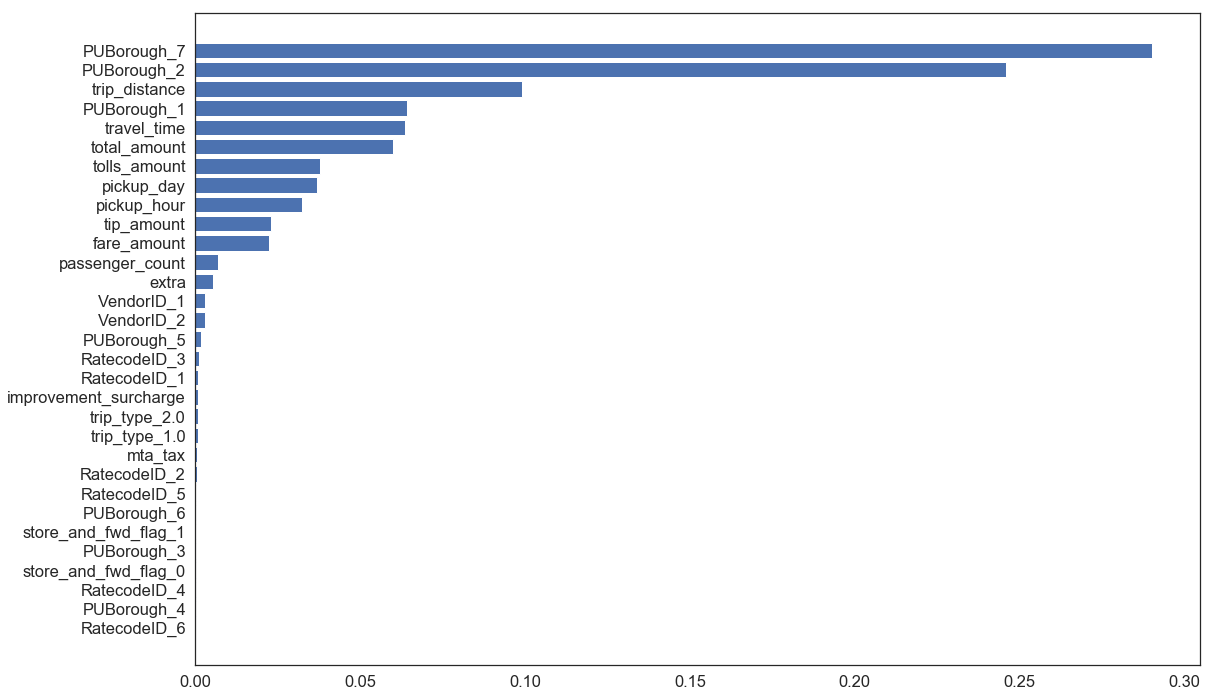

In [79]:
plt.figure(figsize=(18,12))
plt.barh(features_names_sorted, fis_sorted)
plt.show()

### Decision Tree Analysis only Includes Key Features Base on Importances

In [35]:
features_names_sorted

array(['RatecodeID_6', 'PUBorough_4', 'RatecodeID_4', 'PUBorough_3',
       'store_and_fwd_flag_0', 'store_and_fwd_flag_1', 'PUBorough_6',
       'RatecodeID_5', 'RatecodeID_2', 'mta_tax', 'trip_type_1.0',
       'trip_type_2.0', 'improvement_surcharge', 'RatecodeID_3',
       'RatecodeID_1', 'PUBorough_5', 'VendorID_1', 'VendorID_2', 'extra',
       'passenger_count', 'fare_amount', 'tip_amount', 'pickup_hour',
       'pickup_day', 'tolls_amount', 'total_amount', 'travel_time',
       'PUBorough_1', 'trip_distance', 'PUBorough_2', 'PUBorough_7'],
      dtype='<U21')

In [89]:
cols1 = features_names_sorted.tolist()[-10:]
cols1.append('DOBorough')
grouped_df1 = grouped_df[cols1].sample(frac=0.2)
display(grouped_df1.head())
print(len(grouped_df1))
values1 = grouped_df1.values

X1 = values1[:, :-1]
y1 = values1[:, -1]

,tip_amount,pickup_hour,pickup_day,tolls_amount,total_amount,travel_time,PUBorough_1,trip_distance,PUBorough_2,PUBorough_7,DOBorough
466600,0.320158,0.885801,0.532199,-0.190621,-0.525241,-0.163904,1.489010,-0.661180,-0.677862,-0.658391,4
474186,-0.491214,-1.326282,0.646607,-0.190621,-0.753610,-0.175035,1.489010,-0.628954,-0.677862,-0.658391,4
221676,-0.491214,0.035000,-0.611890,-0.190621,1.410674,0.255840,-0.671587,1.054232,1.475226,-0.658391,2
647881,-0.491214,-2.006922,1.676287,-0.190621,-0.790926,-0.181488,-0.671587,-0.703322,-0.677862,1.518855,5
464397,-0.491214,0.715641,0.532199,-0.190621,0.179271,0.039677,-0.671587,-0.187707,-0.677862,1.518855,5


137050


In [98]:
DC = DecisionTreeClassifier()
n = 10
scores1 = []
fis1 = []
for i in range(n):
    X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size = 0.2)
    DC.fit(X_train1, y_train1)
    y_pred1 = DC.predict(X_test1)
    score1 = cross_val_score(DC, X1, y1, scoring="accuracy", cv=5).mean()
    scores1.append(score1)
    fi1 = DC.feature_importances_
    fis1.append(fi1)

In [99]:
print(f"Average of accuracy: {np.mean(scores1)}")
print(f"Standard deviation of accuracy: {np.std(scores1)}")

Average of accuracy: 0.8299095933543649
Standard deviation of accuracy: 0.00037648827983298276


In [100]:
#Average feature importances
fis_avg1 = np.mean(fis1, axis=0)
fis_avg1

array([0.02530762, 0.03911841, 0.04165785, 0.03943241, 0.07908902,
       0.07245666, 0.06386914, 0.10564775, 0.24491363, 0.2885075 ])

In [101]:
np.sort(fis_avg1)
I1 = np.argsort(fis_avg1)
I1

array([0, 1, 3, 2, 6, 5, 4, 7, 8, 9], dtype=int64)

In [102]:
fis_sorted1 = fis_avg1[I1]
features_names_sorted1 = np.array(cols1)[I1]

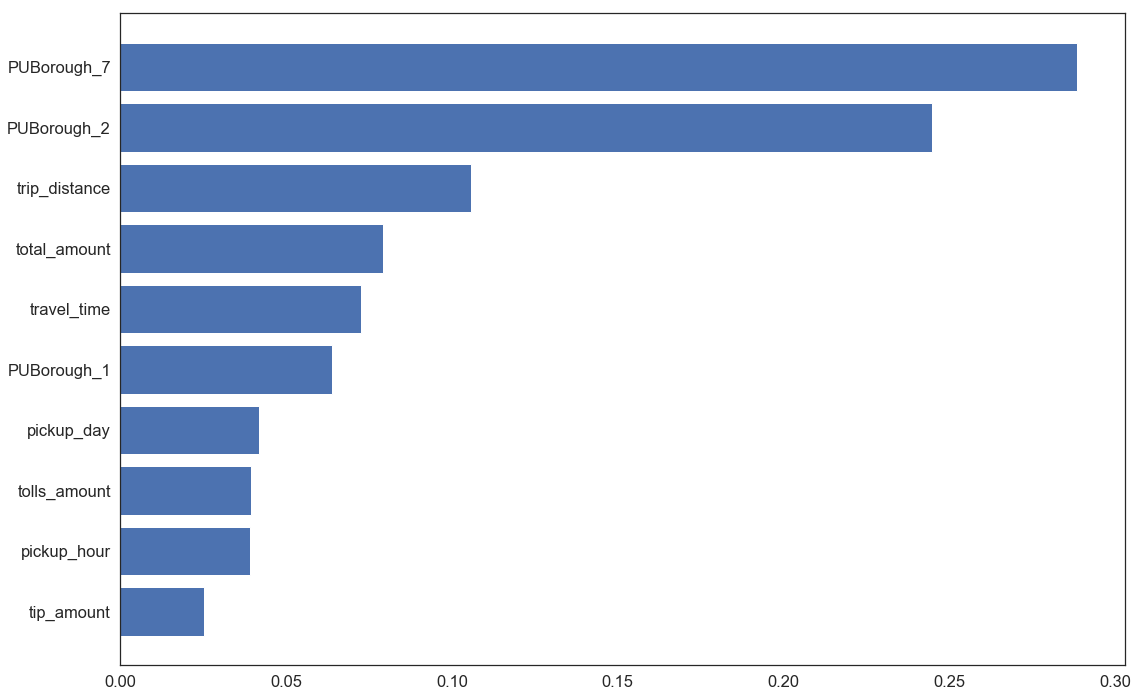

In [103]:
plt.figure(figsize=(18,12))
plt.barh(features_names_sorted1, fis_sorted1)
plt.show()

In [104]:
# Compute the confusion matrix for Decision Tree model with all features
DC_cfmat = skm.confusion_matrix(
    y_true=y_test1,
    y_pred=y_pred1,)
DC_cfmat[:4:4]

array([[1344,   26,    0,  745,   43,    4,   26]], dtype=int64)

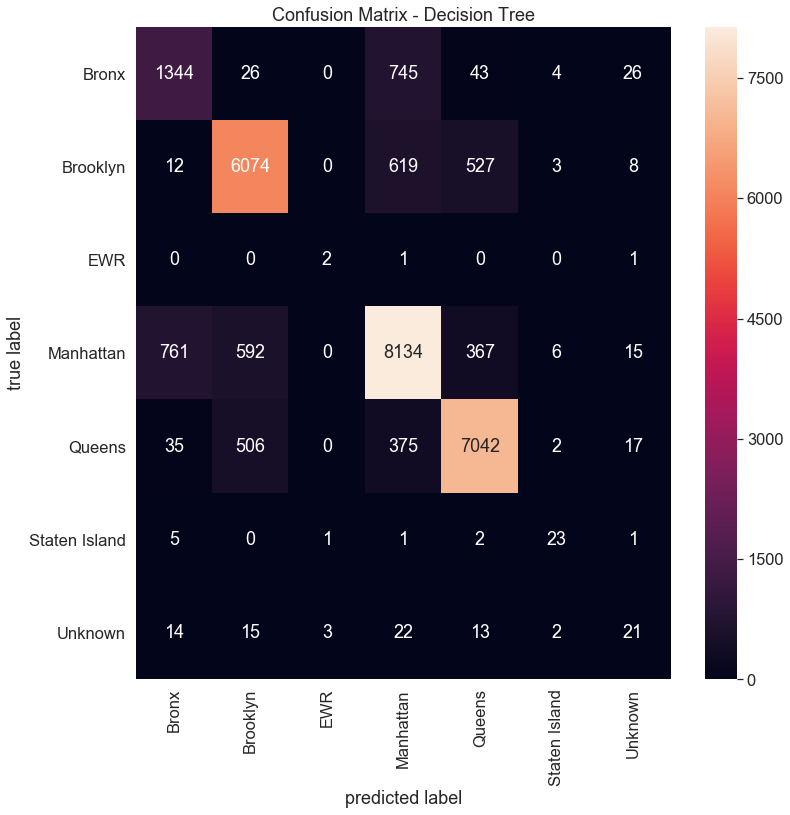

In [105]:
# Visualize the confusion matrix
labels = [Borough[int(i)] for i in np.unique(y_test1)]
sns.heatmap(DC_cfmat, 
            xticklabels=labels,
            yticklabels=labels,
            annot=True, fmt='g')
plt.xlabel('predicted label')
plt.ylabel('true label')
plt.title('Confusion Matrix - Decision Tree')
sns.set(style='white', color_codes=True, font_scale=1.5, rc={'figure.figsize':(12,12)})

After several runs, we noted that the accuracy and importance results generated from Decision Tree is not stable due to the training/test data is randomized for every run. Therefore, we proceeded further with Random Forest model which is a group of random Decision Trees that could help with instability of the training/prediction process. Brooklyn has an accuracy of 0.8402, EWR with 0.8109 and Manhattan with 0.9044.

# Random Forest

## Random Forest Analysis Including all Features

We did not proceed further with iterrations of 10 for random forest given the performance of ARC clusters.

In [140]:
RC = RandomForestClassifier(n_estimators=100, max_features=2)

grouped_df_sample=grouped_df.sample(frac=0.2)
values = grouped_df_sample.values

X_train_sample = values[:, :-1]
y_train_sample = values[:, -1]


X_train, X_test, y_train, y_test = train_test_split(X_train_sample, y_train_sample, test_size = 0.2)
RC.fit(X_train, y_train)
y_pred2 = RC.predict(X_test)
score2 = cross_val_score(RC, X_train_sample, y_train_sample, scoring="accuracy", cv=5).mean()
fi2 = RC.feature_importances_

In [141]:
print(f"Accuracy: {score2}")

Accuracy: 0.8804960495950089


In [142]:
I2 = np.argsort(fi2)
I2

array([19, 26, 16, 23, 22, 29, 17, 15, 20,  9, 30, 21,  6, 18, 14, 12, 13,
        5,  2,  8,  7,  1,  0,  4, 24, 10, 11,  3, 25, 27, 28],
      dtype=int64)

In [143]:
fis_sorted2 = fi2[I2]
features_names_sorted2 = np.array(cols)[I2]

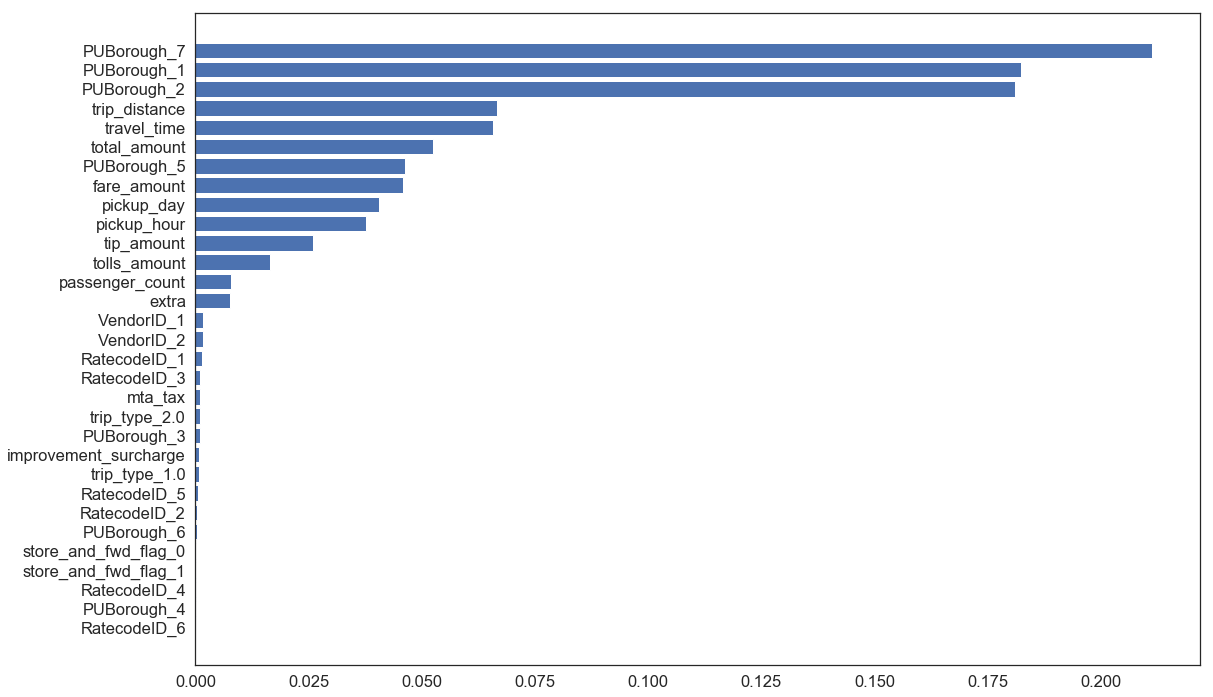

In [144]:
plt.figure(figsize=(18,12))
plt.barh(features_names_sorted2, fis_sorted2)
plt.show()

### Random Forest Analysis only Includes Key Features Base on Importances

In [39]:
features_names_sorted2

array(['PUBorough_4', 'RatecodeID_6', 'PUBorough_6', 'RatecodeID_4',
       'RatecodeID_5', 'PUBorough_3', 'RatecodeID_2',
       'store_and_fwd_flag_1', 'store_and_fwd_flag_0',
       'improvement_surcharge', 'trip_type_2.0', 'RatecodeID_3',
       'trip_type_1.0', 'RatecodeID_1', 'mta_tax', 'VendorID_2',
       'VendorID_1', 'extra', 'passenger_count', 'tolls_amount',
       'tip_amount', 'pickup_hour', 'pickup_day', 'PUBorough_5',
       'fare_amount', 'total_amount', 'travel_time', 'trip_distance',
       'PUBorough_2', 'PUBorough_1', 'PUBorough_7'], dtype='<U21')

In [145]:
cols2 = features_names_sorted2.tolist()[-10:]
cols2.append('DOBorough')

grouped_df2 = grouped_df[cols2].sample(frac=0.2)
display(grouped_df2.head())
values2 = grouped_df2.values

X2 = values2[:, :-1]
y2 = values2[:, -1]

,pickup_hour,pickup_day,fare_amount,PUBorough_5,total_amount,travel_time,trip_distance,PUBorough_2,PUBorough_1,PUBorough_7,DOBorough
676752,0.715641,1.790696,-0.375182,-0.273981,-0.328217,-0.127285,-0.304216,-0.677862,1.489010,-0.658391,4
136424,1.396282,-1.069525,-0.496972,-0.273981,-0.390906,-0.161646,-0.336442,-0.677862,-0.671587,1.518855,5
669809,-0.135160,1.790696,-0.496972,-0.273981,-0.492404,-0.140675,-0.519882,-0.677862,1.489010,-0.658391,4
291853,0.205160,-0.268663,1.248688,-0.273981,1.603220,0.187120,0.709662,-0.677862,1.489010,-0.658391,4
192465,-2.177083,-0.726299,-0.293988,-0.273981,-0.343143,-0.105024,-0.395936,-0.677862,-0.671587,1.518855,5


In [153]:
RC = RandomForestClassifier(n_estimators=100, max_features=2)
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size = 0.2)
RC.fit(X_train2, y_train2)
y_pred2a = RC.predict(X_test2)
score2a = cross_val_score(RC, X2,y2, scoring="accuracy", cv=5).mean()
fi2a = RC.feature_importances_

In [154]:
print(f"Accuracy: {score2a}") #Accuracy score is better using less features. 

Accuracy: 0.8700328561846696


In [155]:
I2a = np.argsort(fi2a)
I2a

array([0, 1, 3, 2, 5, 4, 6, 7, 8, 9], dtype=int64)

In [156]:
fis_sorted2a = fi2a[I2a]
features_names_sorted2a = np.array(cols2)[I2a]

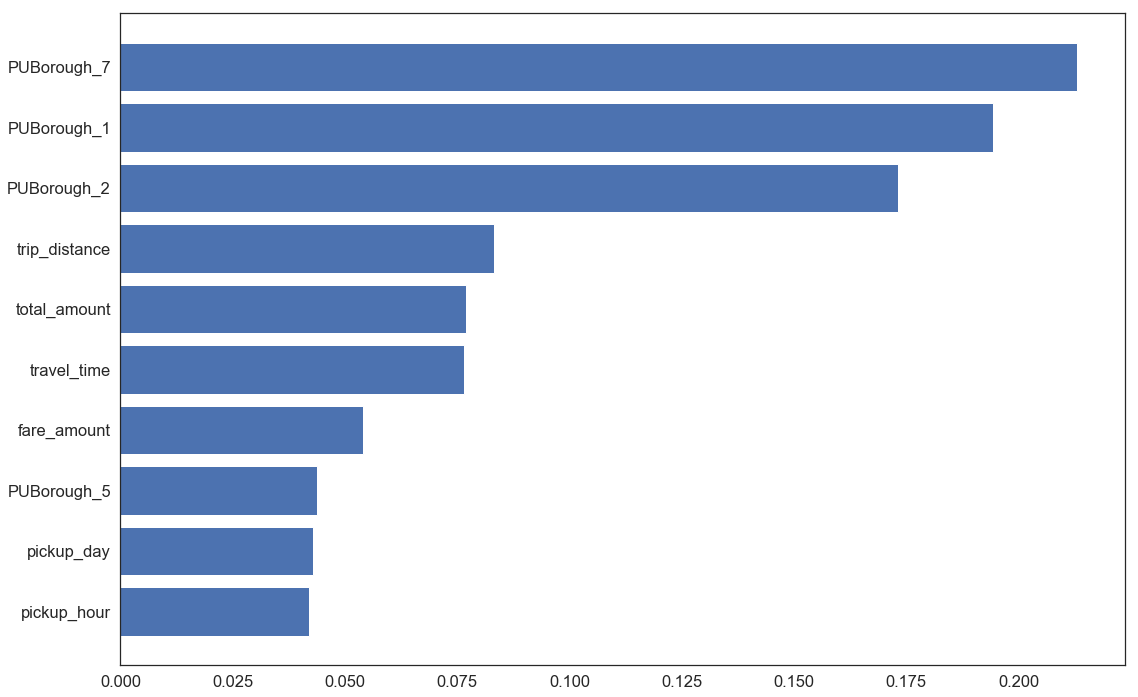

In [157]:
plt.figure(figsize=(18,12))
plt.barh(features_names_sorted2a, fis_sorted2a)
plt.show()

In [158]:
# Compute the confusion matrix for Random Forest model with reduced features
RC_cfmat = skm.confusion_matrix(
    y_true=y_test2,
    y_pred=y_pred2a,)
RC_cfmat[:4:4]

array([[1369,   26,    0,  713,   50,    0,    0]], dtype=int64)

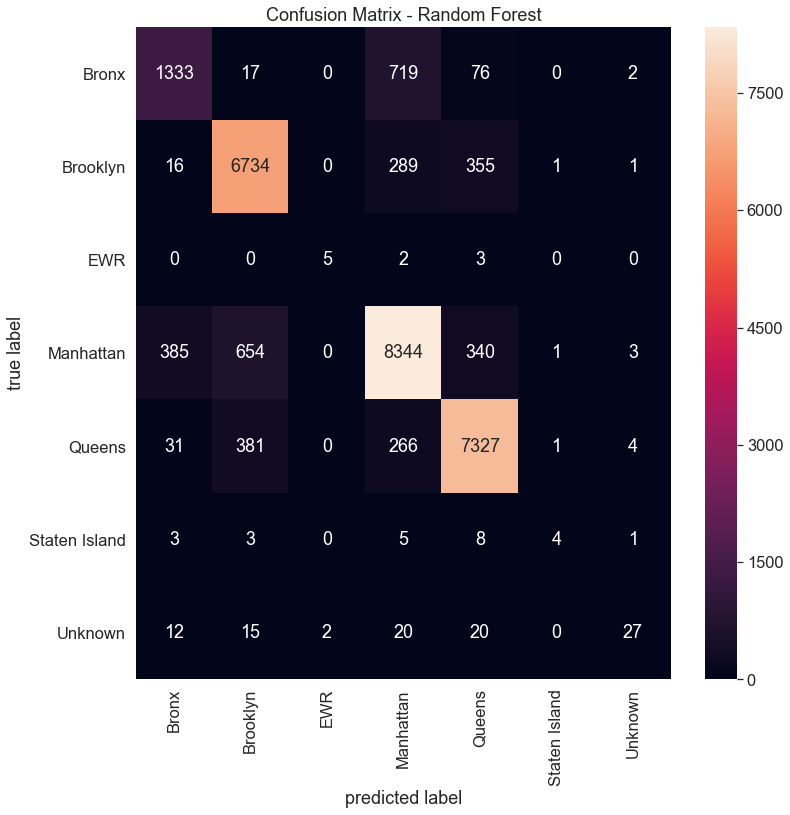

In [152]:
# Visualize the confusion matrix
labels = [Borough[int(i)] for i in np.unique(y_test2)]
sns.heatmap(RC_cfmat, 
            xticklabels=labels,
            yticklabels=labels,
            annot=True, fmt='g')
plt.xlabel('predicted label')
plt.ylabel('true label')
plt.title('Confusion Matrix - Random Forest')
sns.set(style='white', color_codes=True, font_scale=1.5, rc={'figure.figsize':(8,8)})

Based on the Confusion Matrix diagram above, all boroughs have good prediction accuracies especially for boroughs that have the most transactions - Bronx, Brooklyn, Manhattan and Queens. The accuracy of Random Forest has overall higher accuracy, therefore Random Forest is the best model across all three.

# Neural Network

In [27]:
x, unique_value=convert_to_onehot(grouped_df, 'DOBorough')
onehotdict['DOBorough'] = [x, unique_value]
df = pd.DataFrame(onehotdict['DOBorough'][0], columns=['DOBorough' + "_" + str(i) for i in onehotdict['DOBorough'][1]])
grouped_df = grouped_df.join(df)

grouped_df.drop('DOBorough',axis =1, inplace=True)
grouped_df.head()

,pickup_day,pickup_hour,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,...,PUBorough_7,PUBorough_6,PUBorough_3,DOBorough_5,DOBorough_2,DOBorough_4,DOBorough_1,DOBorough_7,DOBorough_6,DOBorough_3
0,-1.641569,-2.347243,-0.323808,-0.852057,-0.902939,0.488934,0.133958,-0.491214,-0.190621,0.268165,...,1.518855,-0.020998,-0.040786,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,-1.641569,-2.347243,-0.323808,-0.467825,-0.496972,0.488934,0.133958,0.476191,-0.190621,0.268165,...,-0.658391,-0.020998,-0.040786,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,-1.641569,-2.347243,0.690181,-0.524840,-0.578165,0.488934,0.133958,-0.491214,-0.190621,0.268165,...,-0.658391,-0.020998,-0.040786,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,-1.641569,-2.347243,0.690181,-0.683491,-0.821746,0.488934,0.133958,0.060103,-0.190621,0.268165,...,-0.658391,-0.020998,-0.040786,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,-1.641569,-2.347243,0.690181,-0.611602,-0.659359,0.488934,0.133958,0.028897,-0.190621,0.268165,...,-0.658391,-0.020998,-0.040786,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [28]:
values = grouped_df.values
X = values[:, :-7]
y = values[:, -7:]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

#### Neural Network Model 1 - all features with a single hidden layer

In [211]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(30, input_dim = X.shape[1], activation ='relu'),
    tf.keras.layers.Dense(y.shape[1], activation = "softmax")
])

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=["accuracy"])
model.fit(X_train, y_train, validation_split = 0.3, epochs = 10, verbose=2, validation_data=(X_test, y_test))

Train on 548200 samples, validate on 137050 samples
Epoch 1/10
 - 60s - loss: 0.3990 - acc: 0.8660 - val_loss: 0.3818 - val_acc: 0.8715
Epoch 2/10
 - 59s - loss: 0.3798 - acc: 0.8729 - val_loss: 0.3822 - val_acc: 0.8720
Epoch 3/10
 - 62s - loss: 0.3818 - acc: 0.8736 - val_loss: 0.3849 - val_acc: 0.8723
Epoch 4/10
 - 61s - loss: 0.3839 - acc: 0.8736 - val_loss: 0.3872 - val_acc: 0.8729
Epoch 5/10
 - 60s - loss: 0.3844 - acc: 0.8743 - val_loss: 0.3846 - val_acc: 0.8745
Epoch 6/10
 - 62s - loss: 0.3848 - acc: 0.8749 - val_loss: 0.3868 - val_acc: 0.8741
Epoch 7/10
 - 59s - loss: 0.3866 - acc: 0.8751 - val_loss: 0.3927 - val_acc: 0.8734
Epoch 8/10
 - 59s - loss: 0.3894 - acc: 0.8748 - val_loss: 0.3917 - val_acc: 0.8736
Epoch 9/10
 - 59s - loss: 0.3935 - acc: 0.8745 - val_loss: 0.3946 - val_acc: 0.8736
Epoch 10/10
 - 59s - loss: 0.3958 - acc: 0.8744 - val_loss: 0.4009 - val_acc: 0.8744


In [212]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_24 (Dense)             (None, 30)                960       
_________________________________________________________________
dense_25 (Dense)             (None, 7)                 217       
Total params: 1,177
Trainable params: 1,177
Non-trainable params: 0
_________________________________________________________________


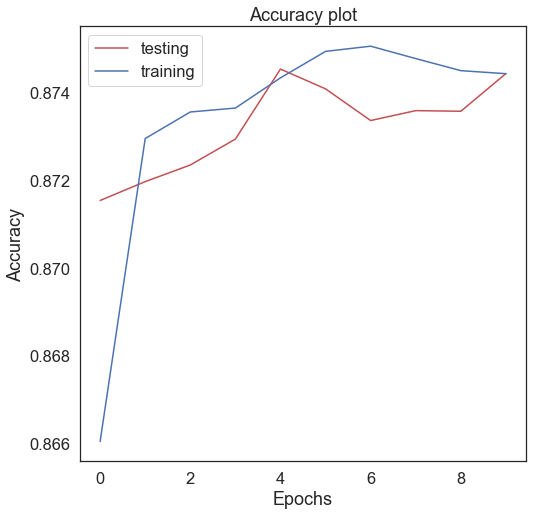

In [213]:
val_acc = model.history.history['val_acc']
acc = model.history.history['acc']

pltx = range(len(acc))
plt.plot(pltx, val_acc,'r', pltx, acc, 'b')
plt.legend(['testing','training'])
plt.title('Accuracy plot')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.show()

In [214]:
score = model.evaluate(X_test, y_test, verbose=0)
print("Score: ", score)

y_test_labels = np.argmax(y_test,axis=1)
y_pred = model.predict_classes(X_test).reshape(-1)

correct_labels = y_pred[y_pred==y_test_labels]
accuracy = sum(y_pred==y_test_labels)/len(y_pred)
print("Correct Labels: ", correct_labels)
print("Accuracy: ", accuracy)

Score:  [0.4009488315742758, 0.8744327]
Correct Labels:  [1 3 4 ... 3 4 3]
Accuracy:  0.8744326887997081


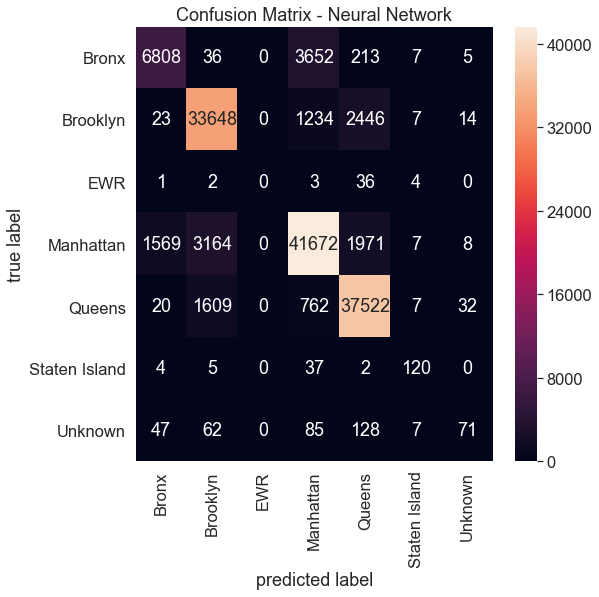

In [215]:
cfmat = skm.confusion_matrix(
    y_true=y_test_labels,
    y_pred=y_pred,)
cfmat[:4:4]

labels = [Borough[int(i+1)] for i in np.unique(y_test_labels)]
sns.heatmap(cfmat, 
            xticklabels=labels,
            yticklabels=labels,
            annot=True, fmt='g')
plt.xlabel('predicted label')
plt.ylabel('true label')
plt.title('Confusion Matrix - Neural Network')
sns.set(style='white', color_codes=True, font_scale=1.5, rc={'figure.figsize':(8,8)})

## Neural Networks

Models were built with variations of increasing the number of layers, increasing the number of nodes, introducing dropout layers and removing predictor variables. The first few models were based on the full dataset with all predictor variables. The above model was built with a single hidden layer and final layer with Softmax activation. The model was initially built with only 10 nodes. When we increased the nodes to 30 the accuracy improved thus we kept the model at 30 nodes producing an accuracy of 0.8730. 

We added a dropout layer of 0.1 to a second model which increases accuracy from 0.8740 to 0.8758 and smooths out the accuracy curve. 
The third model has 6 hidden layers consisting of 3 dense layers and 2 dropout layers. The accuracy was found to decrease and loss increased so we kept the simpler model of two hidden layers (one dense and dropout layer) to test the model check the accuracy of the model with the top 10 features obtained from Random Forest Classifier.

#### Neural Network Model 2
Added dropout layer

In [216]:
model2 = tf.keras.Sequential([
    tf.keras.layers.Dense(30, input_dim = X.shape[1], activation ='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(y.shape[1], activation = "softmax")
])

model2.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=["accuracy"])
model2.fit(X_train, y_train, validation_split = 0.3, epochs = 10, verbose=2, batch_size=128, validation_data=(X_test, y_test))

Train on 548200 samples, validate on 137050 samples
Epoch 1/10
 - 17s - loss: 0.4227 - acc: 0.8571 - val_loss: 0.3716 - val_acc: 0.8693
Epoch 2/10
 - 16s - loss: 0.3762 - acc: 0.8701 - val_loss: 0.3645 - val_acc: 0.8718
Epoch 3/10
 - 16s - loss: 0.3709 - acc: 0.8711 - val_loss: 0.3617 - val_acc: 0.8726
Epoch 4/10
 - 16s - loss: 0.3692 - acc: 0.8718 - val_loss: 0.3602 - val_acc: 0.8733
Epoch 5/10
 - 16s - loss: 0.3692 - acc: 0.8725 - val_loss: 0.3601 - val_acc: 0.8738
Epoch 6/10
 - 16s - loss: 0.3685 - acc: 0.8726 - val_loss: 0.3592 - val_acc: 0.8741
Epoch 7/10
 - 16s - loss: 0.3682 - acc: 0.8730 - val_loss: 0.3582 - val_acc: 0.8751
Epoch 8/10
 - 16s - loss: 0.3679 - acc: 0.8736 - val_loss: 0.3606 - val_acc: 0.8757
Epoch 9/10
 - 16s - loss: 0.3678 - acc: 0.8738 - val_loss: 0.3574 - val_acc: 0.8755
Epoch 10/10
 - 16s - loss: 0.3679 - acc: 0.8738 - val_loss: 0.3573 - val_acc: 0.8761


In [217]:
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_26 (Dense)             (None, 30)                960       
_________________________________________________________________
dropout_8 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense_27 (Dense)             (None, 7)                 217       
Total params: 1,177
Trainable params: 1,177
Non-trainable params: 0
_________________________________________________________________


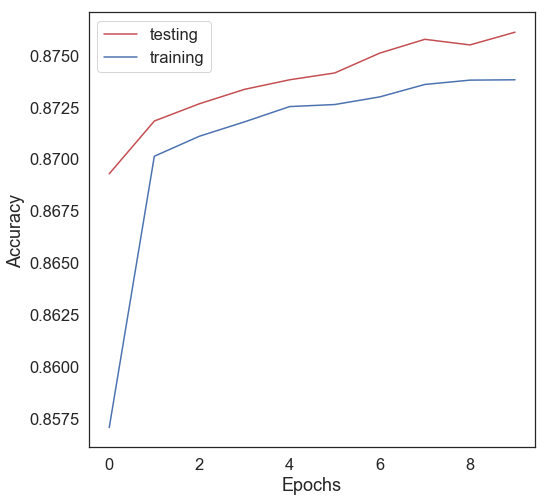

In [218]:
val_acc = model2.history.history['val_acc']
acc = model2.history.history['acc']

pltx = range(len(acc))
plt.plot(pltx, val_acc,'r', pltx, acc, 'b')
plt.legend(['testing','training'])
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.show()

In [219]:
score = model2.evaluate(X_test, y_test, verbose=0)
print("Score: ", score)

y_pred = model2.predict_classes(X_test).reshape(-1)

correct_labels = y_pred[y_pred==y_test_labels]
accuracy = sum(y_pred==y_test_labels)/len(y_pred)
print("Correct Labels: ", correct_labels)
print("Accuracy: ", accuracy)

Score:  [0.3573432050493676, 0.87608904]
Correct Labels:  [1 3 4 ... 3 4 3]
Accuracy:  0.876089018606348


#### Neural Network Model 3
6 layer model

In [220]:
model3 = tf.keras.Sequential([
    tf.keras.layers.Dense(30, input_dim = X.shape[1], activation ='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(20, activation = 'relu'),
    tf.keras.layers.Dense(10, activation = 'relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(y.shape[1], activation = "softmax")
])

model3.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=["accuracy"])
model3.fit(X_train, y_train, validation_split = 0.3, epochs = 10, verbose=2, batch_size=128, validation_data=(X_test, y_test))

Train on 548200 samples, validate on 137050 samples
Epoch 1/10
 - 21s - loss: 0.4657 - acc: 0.8387 - val_loss: 0.3693 - val_acc: 0.8666
Epoch 2/10
 - 20s - loss: 0.3895 - acc: 0.8645 - val_loss: 0.3593 - val_acc: 0.8713
Epoch 3/10
 - 20s - loss: 0.3816 - acc: 0.8673 - val_loss: 0.3523 - val_acc: 0.8749
Epoch 4/10
 - 20s - loss: 0.3769 - acc: 0.8691 - val_loss: 0.3525 - val_acc: 0.8747
Epoch 5/10
 - 20s - loss: 0.3748 - acc: 0.8701 - val_loss: 0.3498 - val_acc: 0.8755
Epoch 6/10
 - 20s - loss: 0.3733 - acc: 0.8704 - val_loss: 0.3488 - val_acc: 0.8763
Epoch 7/10
 - 20s - loss: 0.3723 - acc: 0.8713 - val_loss: 0.3483 - val_acc: 0.8759
Epoch 8/10
 - 21s - loss: 0.3702 - acc: 0.8717 - val_loss: 0.3448 - val_acc: 0.8767
Epoch 9/10
 - 21s - loss: 0.3708 - acc: 0.8721 - val_loss: 0.3456 - val_acc: 0.8769
Epoch 10/10
 - 22s - loss: 0.3722 - acc: 0.8717 - val_loss: 0.3451 - val_acc: 0.8764


In [221]:
model3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_28 (Dense)             (None, 30)                960       
_________________________________________________________________
dropout_9 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense_29 (Dense)             (None, 20)                620       
_________________________________________________________________
dense_30 (Dense)             (None, 10)                210       
_________________________________________________________________
dropout_10 (Dropout)         (None, 10)                0         
_________________________________________________________________
dense_31 (Dense)             (None, 7)                 77        
Total params: 1,867
Trainable params: 1,867
Non-trainable params: 0
_________________________________________________________________


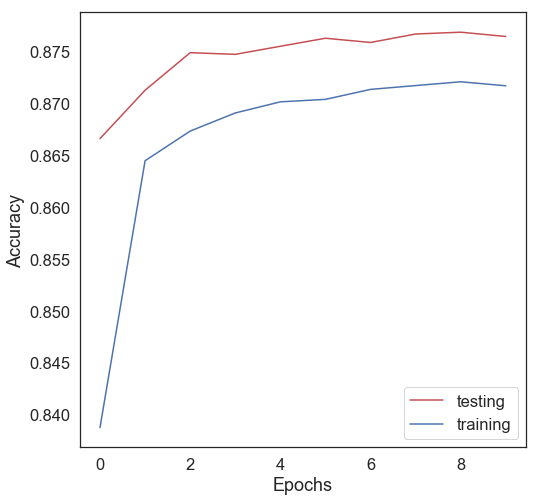

In [222]:
val_acc = model3.history.history['val_acc']
acc = model3.history.history['acc']

pltx = range(len(acc))
plt.plot(pltx, val_acc,'r', pltx, acc, 'b')
plt.legend(['testing','training'])
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.show()

In [223]:
score = model3.evaluate(X_test, y_test, verbose=0)
print("Score: ", score)

y_pred = model3.predict_classes(X_test).reshape(-1)

correct_labels = y_pred[y_pred==y_test_labels]
accuracy = sum(y_pred==y_test_labels)/len(y_pred)
print("Correct Labels: ", correct_labels)
print("Accuracy: ", accuracy)

Score:  [0.345116579612647, 0.87644655]
Correct Labels:  [1 3 4 ... 3 4 3]
Accuracy:  0.8764465523531558


#### Neural Network with smaller feature dataset (top 10 features from Random Forest)

In [29]:
small_df = grouped_df[['pickup_hour', 'pickup_day', 'PUBorough_5',
       'fare_amount', 'total_amount', 'travel_time', 'trip_distance',
       'PUBorough_2', 'PUBorough_1', 'PUBorough_7','DOBorough_5',
       'DOBorough_2', 'DOBorough_4', 'DOBorough_1', 'DOBorough_7',
       'DOBorough_6', 'DOBorough_3']]

In [30]:
values = small_df.values
X1 = values[:, :-7]
y1 = values[:, -7:]

X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size = 0.2)

In [31]:
small_model = tf.keras.Sequential([
    tf.keras.layers.Dense(30, input_dim = X1.shape[1], activation ='relu'),
    tf.keras.layers.Dropout(0.15),
    tf.keras.layers.Dense(y1.shape[1], activation = "softmax")
])

small_model.summary()
small_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=["accuracy"])
small_model.fit(X_train1, y_train1, validation_split = 0.3, epochs = 10, verbose=2, validation_data=(X_test1, y_test1))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 30)                330       
_________________________________________________________________
dropout (Dropout)            (None, 30)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 217       
Total params: 547
Trainable params: 547
Non-trainable params: 0
_________________________________________________________________
Train on 548200 samples, validate on 137050 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/10
 - 51s - loss: 0.4291 - acc: 0.8532 - val_loss: 0.4037 - val_acc: 0.8630
Epoch 2/10
 - 51s - loss: 0.4131 - ac

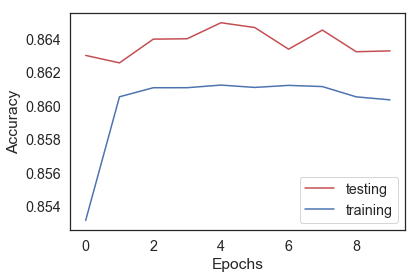

In [32]:
val_acc = small_model.history.history['val_acc']
acc = small_model.history.history['acc']

pltx = range(len(acc))
plt.plot(pltx, val_acc,'r', pltx, acc, 'b')
plt.legend(['testing','training'])
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.show()

In [33]:
score = small_model.evaluate(X_test1, y_test1, verbose=0)
print("Score: ", score)

y_pred1 = small_model.predict_classes(X_test1).reshape(-1)
y_pred1

y_test_labels = np.argmax(y_test1, axis=1)

correct_labels = y_pred1[ y_pred1 == y_test_labels ]
accuracy = sum(y_pred1 == y_test_labels)/len(y_pred1)
print("Correct Labels: ", correct_labels)
print("Accuracy: ", accuracy)

Score:  [0.43450308420065764, 0.86328346]
Correct Labels:  [4 4 4 ... 4 3 4]
Accuracy:  0.863283473184969


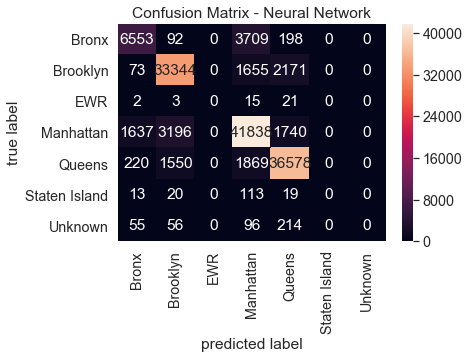

In [36]:
cfmat = skm.confusion_matrix(
    y_true=y_test_labels,
    y_pred=y_pred1,)
cfmat[:4:4]

labels = [Borough[int(i+1)] for i in np.unique(y_test_labels)]
sns.heatmap(cfmat, 
            xticklabels=labels,
            yticklabels=labels,
            annot=True, fmt='g')
plt.xlabel('predicted label')
plt.ylabel('true label')
plt.title('Confusion Matrix - Neural Network')
sns.set(style='white', color_codes=True, font_scale=1.5, rc={'figure.figsize':(10,10)})

## Neural Network with 10 features

The variables were chosen by highest importance consisting of 'pickup_hour', 'pickup_day', 'PUBorough_5', 'fare_amount', 'total_amount', 'travel_time', 'trip_distance','PUBorough_2', 'PUBorough_1', 'PUBorough_7' for above model. 
The accuracy decreased slightly and the accuracy plot is more stable than the testing dataset suggesting that the model is not detecting the major patterns of the model. However, the model is in a closer range to the testing set's accuracy which is much closer than the other models.

Below model was obtained by decreasing the number of predictor variables to 3; mainly PUBorough information (1: Bronx, 2: Brooklyn, and 7: Unknown). The model was found to be decrease in accuracy by 4%.

#### Model with 3 features

In [37]:
small_df = grouped_df[['PUBorough_2', 'PUBorough_1', 'PUBorough_7',
                       'DOBorough_5', 'DOBorough_2', 'DOBorough_4', 'DOBorough_1', 
                       'DOBorough_7', 'DOBorough_6', 'DOBorough_3']]

In [38]:
values = small_df.values
X1 = values[:, :-7]
y1 = values[:, -7:]

X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size = 0.2)

In [39]:
small_model = tf.keras.Sequential([
    tf.keras.layers.Dense(10, input_dim = X1.shape[1], activation ='relu'),
    tf.keras.layers.Dense(y1.shape[1], activation = "softmax")
])

small_model.summary()
small_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=["accuracy"])
small_model.fit(X_train1, y_train1, validation_split = 0.3, epochs = 10, verbose=2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 10)                40        
_________________________________________________________________
dense_3 (Dense)              (None, 7)                 77        
Total params: 117
Trainable params: 117
Non-trainable params: 0
_________________________________________________________________
Train on 383740 samples, validate on 164460 samples
Epoch 1/10
 - 39s - loss: 0.6207 - acc: 0.8271 - val_loss: 0.5992 - val_acc: 0.8348
Epoch 2/10
 - 37s - loss: 0.5988 - acc: 0.8343 - val_loss: 0.5990 - val_acc: 0.8348
Epoch 3/10
 - 37s - loss: 0.5987 - acc: 0.8343 - val_loss: 0.5994 - val_acc: 0.8348
Epoch 4/10
 - 37s - loss: 0.5988 - acc: 0.8343 - val_loss: 0.5993 - val_acc: 0.8348
Epoch 5/10
 - 37s - loss: 0.5991 - acc: 0.8343 - val_loss: 0.6003 - val_acc: 0.8348
Epoch 6/10
 - 37s - loss: 0.5994 - acc: 0.8343 - val_loss: 0.5992 - 

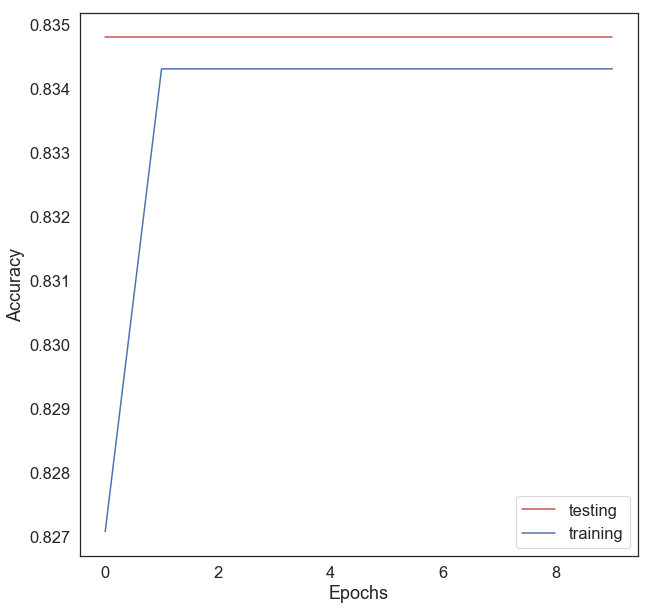

In [40]:
val_acc = small_model.history.history['val_acc']
acc = small_model.history.history['acc']

pltx = range(len(acc))
plt.plot(pltx, val_acc,'r', pltx, acc, 'b')
plt.legend(['testing','training'])
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.show()

In [41]:
score = small_model.evaluate(X_test1, y_test1, verbose=0)
print("Score: ", score)

y_pred1 = small_model.predict_classes(X_test1).reshape(-1)
y_pred1

y_test_labels = np.argmax(y_test1, axis=1)

correct_labels = y_pred1[ y_pred1 == y_test_labels ]
accuracy = sum(y_pred1 == y_test_labels)/len(y_pred1)
print("Correct Labels: ", correct_labels)
print("Accuracy: ", accuracy)

Score:  [0.6025647141536802, 0.8340241]
Correct Labels:  [1 0 3 ... 4 3 1]
Accuracy:  0.8340240788033565


### Conclusion

From the classification models: KNN, Decision Tree and Random Forest Classifer; the Random Forest Classifier was found to predict the drop off borough with the highest accuracy of 0.8805 for model including all the predictor variables and 0.8700 when only including the top 10 features. The features with highest importances were pickup boroughs (1: Bronx, 2: Brooklyn, 5: Queens, and 7: Unknown), total amount, travel time, trip distance, fare amount, pick up hour and day.

We built a neural network model with two hidden layers of Dense and Dropout layers with a Softmax output layer. With the variables we used to train the model, increasing the layers and increasing dropout layer did not improve the model. Also, increasing the number of epochs did not improve the accuracy. We decided to keep the model simple with the two hidden layers and trained with the top 10 variables. The network was able to obtain slightly lower accuracy compared to KNN, and Random Forest Classifier.
